   *«Золото твёрже стали, поскольку сталь подчиняется ему.»*

   -- Японская пословица

# Температура при легировании

В данной работе будут исследоваться возможности уменьшения электропотребления этапа обработки стали металургического комбината «Стальная птица». В ходе выполнения этого анализа будет построена модель предсказания температуры сплава, находящегося на этапе легирования. Далее будет произведён анализ факторов влияющих на данную модель на основании которого можно будет сделать выводы о возможных способах уменьшения электропотребления. Кроме того, построенную модель можно будет использовать для предсказания температуры датчика в данном ковше.

## Данные

In [108]:
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.metrics import mean_absolute_error

from sklearn.preprocessing import StandardScaler

Извлечём имеющиеся данные и посмотрим на них.

### Электроды

Данные об электродах содержат информацию о времени нагрева при соответсвующей мощности для каждой партии. Многии партии подвергались нагреву несколько раз.

In [2]:
data_e = pd.read_csv('/datasets/data_arc_new.csv') # данные об электродах

data_e.head(10)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856


Существуют данные о нагреве для 3214 партий.

In [3]:
len(data_e['key'].unique())

3214

Однако максимальный номер партии 3241. Это значит, что 27 партий пропущено.

In [4]:
data_e['key'].unique()

array([   1,    2,    3, ..., 3239, 3240, 3241])

Существует одна запись с отрицательным значением мощности, что будем считать ошибкой.

In [5]:
data_e.loc[(data_e['Реактивная мощность'] < 0) | (data_e['Активная мощность'] < 0)]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


Исключим из рассмотрения партию, где встретилась данная ошибка.

In [6]:
data_e[data_e['key'] == data_e.loc[data_e['Реактивная мощность'] < 0, 'key'].values[0]]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9778,2116,2019-07-28 02:07:12,2019-07-28 02:09:14,0.787549,0.693881
9779,2116,2019-07-28 02:13:10,2019-07-28 02:15:25,0.580263,0.411498
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924
9781,2116,2019-07-28 02:29:11,2019-07-28 02:30:18,0.563641,0.408513


In [7]:
data_e = data_e.drop(
    data_e[data_e['key'] == data_e.loc[data_e['Реактивная мощность'] < 0, 'key'].values[0]].index
).reset_index(drop=True)

Ожидаемо активная и реактивная мощности имеют высокую положительную корреляцию.

In [8]:
data_e['Активная мощность'].corr(data_e['Реактивная мощность'])

0.9663821708188477

In [9]:
data_e.groupby(data_e['key']).sum()['Активная мощность'].corr(data_e.groupby(data_e['key']).sum()['Реактивная мощность'])

0.9925177522419708

И схожие распределения. Отдельно стоит отметить, что суммарное по партиям распределения мощностей выглядят ближе к нормальному, чем распределения мощностей по партиям.

<div class="alert alert-info">
<b>Комментарий:</b>
<br>Я сомневаюсь, что мощностью нагревателя в ~1 Вт можно нагреть даже стакан с водой, но по условию задачи данные даны в СИ, так что..
</div>

Text(0.5, 0, 'мощность, Вт')

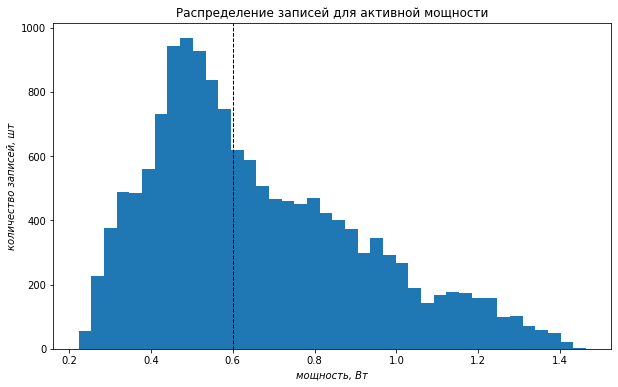

In [10]:
data_e['Активная мощность'].hist(
    bins=40,
    figsize=(10,6),
    grid=False
)
plt.axvline(x=data_e['Активная мощность'].median(), color='#000000', ls='--', linewidth=1)
plt.title('Распределение записей для активной мощности')
plt.ylabel('количество записей, шт', style='italic')
plt.xlabel('мощность, Вт', style='italic')

Text(0.5, 0, 'мощность, Вт')

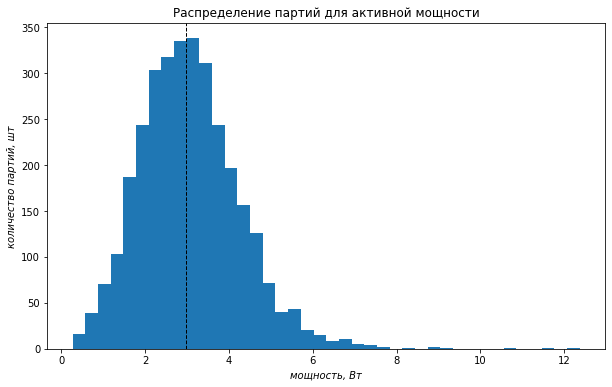

In [11]:
data_e.groupby(data_e['key']).sum()['Активная мощность'].hist(
    bins=40,
    figsize=(10,6),
    grid=False
)
plt.axvline(x=data_e.groupby(data_e['key']).sum()['Активная мощность'].median(), color='#000000', ls='--', linewidth=1)
plt.title('Распределение партий для активной мощности')
plt.ylabel('количество партий, шт', style='italic')
plt.xlabel('мощность, Вт', style='italic')

Text(0.5, 0, 'мощность, Вт')

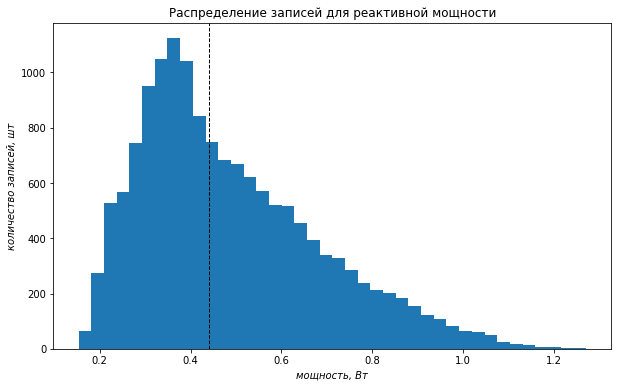

In [12]:
data_e['Реактивная мощность'].hist(
    bins=40,
    figsize=(10,6),
    grid=False
)
plt.axvline(x=data_e['Реактивная мощность'].median(), color='#000000', ls='--', linewidth=1)
plt.title('Распределение записей для реактивной мощности')
plt.ylabel('количество записей, шт', style='italic')
plt.xlabel('мощность, Вт', style='italic')

Text(0.5, 0, 'мощность, Вт')

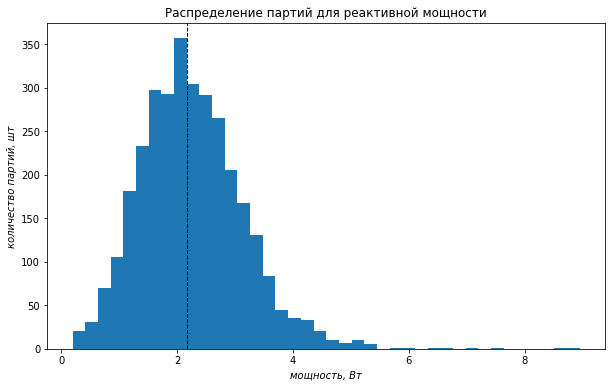

In [13]:
data_e.groupby(data_e['key']).sum()['Реактивная мощность'].hist(
    bins=40,
    figsize=(10,6),
    grid=False
)
plt.axvline(x=data_e.groupby(data_e['key']).sum()['Реактивная мощность'].median(), color='#000000', ls='--', linewidth=1)
plt.title('Распределение партий для реактивной мощности')
plt.ylabel('количество партий, шт', style='italic')
plt.xlabel('мощность, Вт', style='italic')

Преобразуем данные о времени в более подходящий тип данных.

In [14]:
data_e['Начало нагрева дугой'] = pd.to_datetime(data_e['Начало нагрева дугой'], format='%Y-%m-%d %H:%M:%S')
data_e['Конец нагрева дугой'] = pd.to_datetime(data_e['Конец нагрева дугой'], format='%Y-%m-%d %H:%M:%S')

Для текущих данных не найдены пропуски или повторы.

In [15]:
data_e.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14872 entries, 0 to 14871
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14872 non-null  int64         
 1   Начало нагрева дугой  14872 non-null  datetime64[ns]
 2   Конец нагрева дугой   14872 non-null  datetime64[ns]
 3   Активная мощность     14872 non-null  float64       
 4   Реактивная мощность   14872 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.1 KB


### Сыпучие материалы

#### Объём

In [16]:
data_mv = pd.read_csv('/datasets/data_bulk_new.csv') # данные об объёмах сыпучих материалов

data_mv.head(10)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0


Существуют данные о засыпках для 3129 партий.

In [17]:
len(data_mv['key'].unique())

3129

Однако максимальная партия с номером 3241. В этот раз пропущенно 112 партий.

In [18]:
data_mv['key'].unique()

array([   1,    2,    3, ..., 3239, 3240, 3241])

Ни для одной из партий не требовалось засыпать материалы несколько раз. (или в данной таблице представлены суммарные объёмы всех засыпок для каждой партии)

In [19]:
data_mv['key'].duplicated().sum()

0

В данной таблице пропуски означают, что для указанной партии засыпка соответсвующих материалов не проводилась, т.о. объём добавленого материала равен нулю.

In [20]:
data_mv = data_mv.fillna(0)

В данных нет засыпок с отрицательным объёмом.

In [21]:
(data_mv[data_mv.columns.drop('key')] < 0).sum()

Bulk 1     0
Bulk 2     0
Bulk 3     0
Bulk 4     0
Bulk 5     0
Bulk 6     0
Bulk 7     0
Bulk 8     0
Bulk 9     0
Bulk 10    0
Bulk 11    0
Bulk 12    0
Bulk 13    0
Bulk 14    0
Bulk 15    0
dtype: int64

Для каждой из партий требовалась засыпка хотябы одного сыпучего материала.

In [22]:
(data_mv[data_mv.columns.drop('key')].T.sum() <= 0).sum()

0

Распределения объёмов засыпаемых сыпучих материалов выглядит следующим образом:

array([[<AxesSubplot:title={'center':'Bulk 1'}>,
        <AxesSubplot:title={'center':'Bulk 2'}>,
        <AxesSubplot:title={'center':'Bulk 3'}>,
        <AxesSubplot:title={'center':'Bulk 4'}>],
       [<AxesSubplot:title={'center':'Bulk 5'}>,
        <AxesSubplot:title={'center':'Bulk 6'}>,
        <AxesSubplot:title={'center':'Bulk 7'}>,
        <AxesSubplot:title={'center':'Bulk 8'}>],
       [<AxesSubplot:title={'center':'Bulk 9'}>,
        <AxesSubplot:title={'center':'Bulk 10'}>,
        <AxesSubplot:title={'center':'Bulk 11'}>,
        <AxesSubplot:title={'center':'Bulk 12'}>],
       [<AxesSubplot:title={'center':'Bulk 13'}>,
        <AxesSubplot:title={'center':'Bulk 14'}>,
        <AxesSubplot:title={'center':'Bulk 15'}>, <AxesSubplot:>]],
      dtype=object)

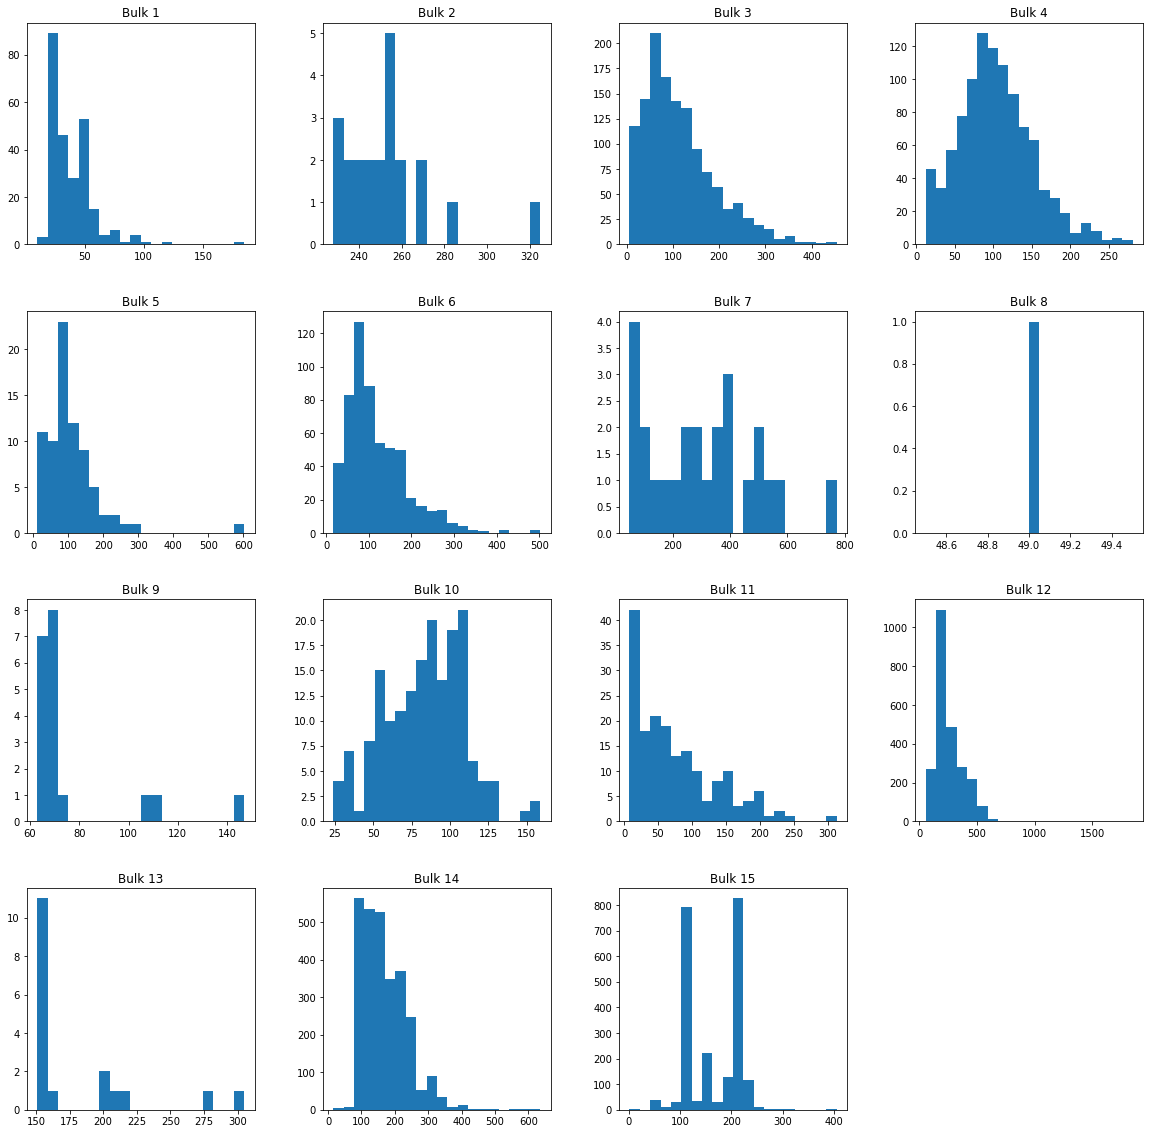

In [23]:
data_mv[data_mv[data_mv.columns.drop('key')] > 0].drop('key', axis=1).hist(
    bins=20,
    figsize=(20, 20),
    grid=False
)

In [24]:
data_mv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   3129 non-null   float64
 2   Bulk 2   3129 non-null   float64
 3   Bulk 3   3129 non-null   float64
 4   Bulk 4   3129 non-null   float64
 5   Bulk 5   3129 non-null   float64
 6   Bulk 6   3129 non-null   float64
 7   Bulk 7   3129 non-null   float64
 8   Bulk 8   3129 non-null   float64
 9   Bulk 9   3129 non-null   float64
 10  Bulk 10  3129 non-null   float64
 11  Bulk 11  3129 non-null   float64
 12  Bulk 12  3129 non-null   float64
 13  Bulk 13  3129 non-null   float64
 14  Bulk 14  3129 non-null   float64
 15  Bulk 15  3129 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


#### Время

Данная таблица не понадобится нам для анализа, однако мы можем проанализировать данные в ней.

In [25]:
data_mt = pd.read_csv('/datasets/data_bulk_time_new.csv') # данные о времени сыпучих материалов

data_mt.head(10)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47
5,6,NaN,NaN,NaN,2019-05-03 13:57:27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:48:52,NaN,2019-05-03 14:09:42,2019-05-03 14:03:15
6,7,NaN,NaN,NaN,2019-05-03 14:18:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:41:26,NaN,2019-05-03 14:30:50,2019-05-03 14:27:16
7,8,NaN,NaN,NaN,2019-05-03 15:17:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 15:17:58,NaN,2019-05-03 15:13:18,2019-05-03 15:05:33
8,9,NaN,NaN,NaN,2019-05-03 16:03:08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:03:08,NaN,2019-05-03 16:00:16,2019-05-03 15:52:39
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:38:11,NaN,2019-05-03 16:34:24,2019-05-03 16:29:56


Существуют данные о засыпках для 3129 партий.

In [26]:
len(data_mt['key'].unique())

3129

Однако максимальная партия с номером 3241. В этот раз пропущенно 112 партий.

In [27]:
data_mt['key'].unique()

array([   1,    2,    3, ..., 3239, 3240, 3241])

Ни для одной из партий не требовалось засыпать материалы несколько раз. (или в данной таблице представлено начальное/конечное/среднее/примерное время для всех засыпок на каждой партии)

In [28]:
data_mt['key'].duplicated().sum()

0

Можно заполнить пропуски нулями, также как было сделано с соответсвующей таблицей по объёму.

In [29]:
data_mt = data_mt.fillna(0)

Для каждой из партий требовалась засыпка хотябы одного сыпучего материала.

In [30]:
(data_mt[data_mt.columns.drop('key')].T.sum() <= 0).sum()

0

In [31]:
data_mt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   3129 non-null   object
 2   Bulk 2   3129 non-null   object
 3   Bulk 3   3129 non-null   object
 4   Bulk 4   3129 non-null   object
 5   Bulk 5   3129 non-null   object
 6   Bulk 6   3129 non-null   object
 7   Bulk 7   3129 non-null   object
 8   Bulk 8   3129 non-null   object
 9   Bulk 9   3129 non-null   object
 10  Bulk 10  3129 non-null   object
 11  Bulk 11  3129 non-null   object
 12  Bulk 12  3129 non-null   object
 13  Bulk 13  3129 non-null   object
 14  Bulk 14  3129 non-null   object
 15  Bulk 15  3129 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


### Газ

In [32]:
data_g = pd.read_csv('/datasets/data_gas_new.csv') # данные о продувке сплава газом

data_g.head(10)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891


Существуют данные о засыпках для 3239 партий.

In [33]:
len(data_g['key'].unique())

3239

Однако максимальная партия с номером 3241. Пропущенно всего 2 партии.

In [34]:
data_g['key'].unique()

array([   1,    2,    3, ..., 3239, 3240, 3241])

Продувка газом использовалась для каждой из указанных в данных партий.

In [35]:
(data_g['Газ 1'] <= 0).sum()

0

Распределение объёма газа для продувки приближено к нормальному виду. Существуют отдельные значения для которых объёмы затраченного газа превышают медианное значение по объёмам газа для остальных партий, однако такие значения будут рассматриваться нами как имеющие смысл.

Text(0.5, 0, 'Объём, $м^3$')

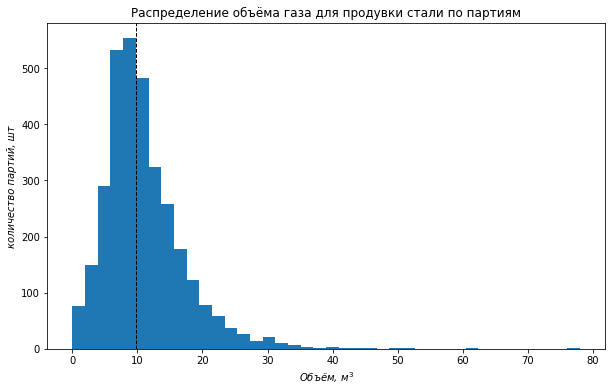

In [36]:
data_g['Газ 1'].hist(
    bins=40,
    figsize=(10,6),
    grid=False
)
plt.axvline(x=data_g['Газ 1'].median(), color='#000000', ls='--', linewidth=1)
plt.title('Распределение объёма газа для продувки стали по партиям')
plt.ylabel('количество партий, шт', style='italic')
plt.xlabel('Объём, $м^3$', style='italic')

Данные о газе не имеют пропусков или повторов.

In [37]:
data_g.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


### Температура

Также как и в таблице об электродах данные о температуре содержат несколько записей для каждой партии.

In [38]:
data_t = pd.read_csv('/datasets/data_temp_new.csv') # данные о температуре

data_t.head(10)

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0
7,2,2019-05-03 11:38:40,1577.0
8,2,2019-05-03 11:46:09,1589.0
9,2,2019-05-03 11:49:38,1604.0


В данной таблице собраны данные о 3216 партиях.

In [39]:
len(data_t['key'].unique())

3216

Преобразуем данные о времени в более подходящий тип данных.

In [40]:
data_t['Время замера'] = pd.to_datetime(data_t['Время замера'], format='%Y-%m-%d %H:%M:%S')

Температура кристализации данной стали ~1400 °C, однако в данных существуют записи с температурой ниже.

In [41]:
for i in data_t.loc[data_t['Температура'] <= 1400, 'key'].values:
    display(data_t[data_t['key'] == i])

,key,Время замера,Температура
4883,867,2019-06-06 08:03:39,1191.0
4884,867,2019-06-06 08:18:52,1575.0
4885,867,2019-06-06 08:22:38,1576.0
4886,867,2019-06-06 08:25:11,1571.0
4887,867,2019-06-06 08:29:49,1600.0
4888,867,2019-06-06 08:36:49,1522.0
4889,867,2019-06-06 08:43:02,1521.0
4890,867,2019-06-06 08:48:23,1599.0


,key,Время замера,Температура
6784,1214,2019-06-18 08:01:03,1208.0
6785,1214,2019-06-18 08:17:56,1608.0
6786,1214,2019-06-18 08:31:10,1608.0
6787,1214,2019-06-18 08:43:56,1591.0


,key,Время замера,Температура
9050,1619,2019-07-03 02:34:41,1218.0
9051,1619,2019-07-03 02:39:29,1623.0
9052,1619,2019-07-03 02:43:59,1590.0


,key,Время замера,Температура
11495,2052,2019-07-25 08:49:15,1227.0
11496,2052,2019-07-25 08:54:39,1592.0
11497,2052,2019-07-25 09:03:59,1590.0
11498,2052,2019-07-25 09:07:19,1591.0
11499,2052,2019-07-25 09:20:11,1515.0
11500,2052,2019-07-25 09:27:03,1592.0


,key,Время замера,Температура
14283,2561,2019-08-12 18:49:29,1204.0
14284,2561,2019-08-12 18:59:23,NaN
14285,2561,2019-08-12 19:06:26,NaN
14286,2561,2019-08-12 19:11:13,NaN
14287,2561,2019-08-12 19:17:08,NaN
14288,2561,2019-08-12 19:21:45,NaN


Следует убрать все партии, имеющие на любом из этапов температуру ниже температуры плавления, как партии с ошибкой.

In [42]:
for i in data_t.loc[data_t['Температура'] <= 1400, 'key'].values:
    data_t = data_t.drop(data_t[data_t['key'] == i].index).reset_index(drop=True)

В дальнейшем анализе нам понадобятся значения температуры стали на входе (самая ранняя запись о температуре) и температуры стали на выходе (самая поздняя запись о температуре), поэтому стоит удалить строки с соотвестсвующими пропущенными значиниями, как не имеющие смысла для дальнейшего анализа.

<div class="alert alert-info">
<b>Комментарий:</b>
<br>Здесь между скоростью выполнения и структурой логики анализа я выбрал последнее.
</div>

In [43]:
data_t = data_t[data_t['key'].isin(
    data_t.groupby('key').count() [ \
        (data_t.groupby('key').apply(
            lambda x: x[x['Время замера'] == x['Время замера'].max()]
        ).set_index('key')['Температура'].notna()) & \
        (data_t.groupby('key').apply(
            lambda x: x[x['Время замера'] == x['Время замера'].max()]
        ).set_index('key')['Температура'].notna())
    ].index
)]

Количество записей о партиях сократилось примерно на четверть после данного шага.

In [44]:
len(data_t['key'].unique())

2473

Из рисунков ниже видно, что входная температура имеет более широкое распределение и меньшую медиану, по сравнению с выходной.

Text(0.5, 0, 'температура, °C')

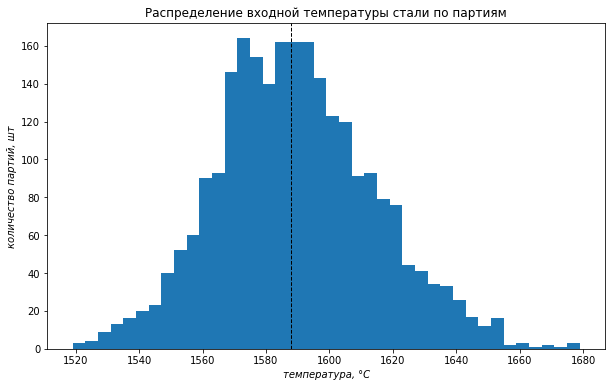

In [45]:
data_t.groupby('key').apply(
    lambda x: x[x['Время замера'] == x['Время замера'].min()]
).set_index('key')['Температура'].hist(
    bins=40,
    figsize=(10,6),
    grid=False
)
plt.axvline(x=data_t.groupby('key').apply(
        lambda x: x[x['Время замера'] == x['Время замера'].min()]
    ).set_index('key')['Температура'].median(), color='#000000', ls='--', linewidth=1)
plt.title('Распределение входной температуры стали по партиям')
plt.ylabel('количество партий, шт', style='italic')
plt.xlabel('температура, °C', style='italic')

Text(0.5, 0, 'температура, °C')

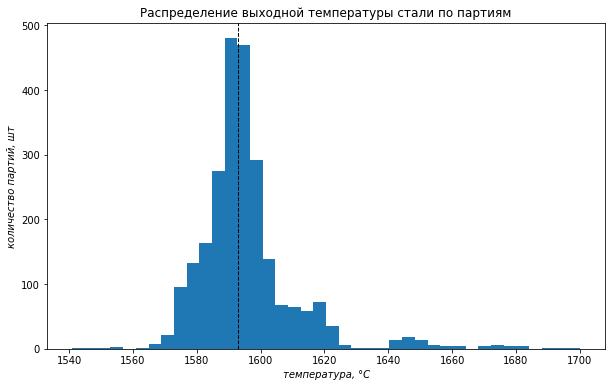

In [46]:
data_t.groupby('key').apply(
    lambda x: x[x['Время замера'] == x['Время замера'].max()]
).set_index('key')['Температура'].hist(
    bins=40,
    figsize=(10,6),
    grid=False
)
plt.axvline(x=data_t.groupby('key').apply(
        lambda x: x[x['Время замера'] == x['Время замера'].max()]
    ).set_index('key')['Температура'].median(), color='#000000', ls='--', linewidth=1)
plt.title('Распределение выходной температуры стали по партиям')
plt.ylabel('количество партий, шт', style='italic')
plt.xlabel('температура, °C', style='italic')

Кроме того можно построить распределение разницы температуры между выходом и входом.

Text(0.5, 0, 'температура, °C')

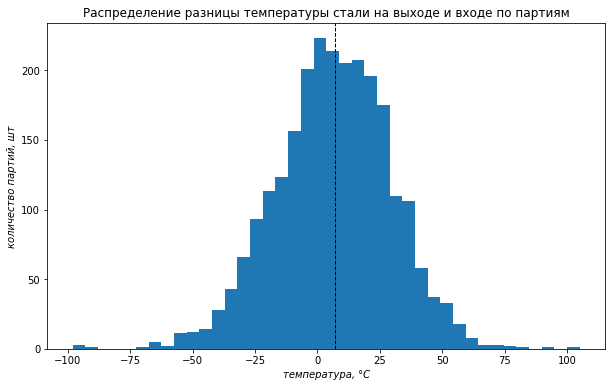

In [47]:
(data_t.groupby('key').apply(
    lambda x: x[x['Время замера'] == x['Время замера'].max()]
).set_index('key')['Температура'] - \
data_t.groupby('key').apply(
    lambda x: x[x['Время замера'] == x['Время замера'].min()]
).set_index('key')['Температура']).hist(
    bins=40,
    figsize=(10,6),
    grid=False
)
plt.axvline(x=(data_t.groupby('key').apply(
        lambda x: x[x['Время замера'] == x['Время замера'].max()]
    ).set_index('key')['Температура'] - \
    data_t.groupby('key').apply(
        lambda x: x[x['Время замера'] == x['Время замера'].min()]
    ).set_index('key')['Температура']).median(), color='#000000', ls='--', linewidth=1)
plt.title('Распределение разницы температуры стали на выходе и входе по партиям')
plt.ylabel('количество партий, шт', style='italic')
plt.xlabel('температура, °C', style='italic')

In [48]:
data_t.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13905 entries, 0 to 13904
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           13905 non-null  int64         
 1   Время замера  13905 non-null  datetime64[ns]
 2   Температура   13905 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 434.5 KB


### Проволочные материалы

#### Объём

In [49]:
data_wv = pd.read_csv('/datasets/data_wire_new.csv') # данные об объёме проволочных материалов

data_wv.head(10)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,98.061600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,155.282394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,113.393279,9.143681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,81.244796,12.376000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Существуют данные о засыпках для 3081 партии.

In [50]:
len(data_wv['key'].unique())

3081

Максимальный номер партии -- 3241. Пропущенно 160 партий.

In [51]:
data_wv['key'].unique()

array([   1,    2,    3, ..., 3239, 3240, 3241])

Ни для одной из партий не требовалось засыпать материалы несколько раз. (или в данной таблице представлены суммарные объёмы всех засыпок для каждой партии)

In [52]:
data_wv['key'].duplicated().sum()

0

В данной таблице пропуски означают, что для указанной партии засыпка соответсвующих проволок не проводилась, т.о. объём добавленого материала равен нулю.

In [53]:
data_wv = data_wv.fillna(0)

В данных нет засыпок с отрицательным объёмом.

In [54]:
(data_wv[data_wv.columns.drop('key')] < 0).sum()

Wire 1    0
Wire 2    0
Wire 3    0
Wire 4    0
Wire 5    0
Wire 6    0
Wire 7    0
Wire 8    0
Wire 9    0
dtype: int64

Для каждой из партий требовалась засыпка хотябы одного из типов проволочных материалов.

In [55]:
(data_wv[data_wv.columns.drop('key')].T.sum() <= 0).sum()

0

Распределения объёмов засыпаемых проволочных материалов выглядит следующим образом:

array([[<AxesSubplot:title={'center':'Wire 1'}>,
        <AxesSubplot:title={'center':'Wire 2'}>,
        <AxesSubplot:title={'center':'Wire 3'}>],
       [<AxesSubplot:title={'center':'Wire 4'}>,
        <AxesSubplot:title={'center':'Wire 5'}>,
        <AxesSubplot:title={'center':'Wire 6'}>],
       [<AxesSubplot:title={'center':'Wire 7'}>,
        <AxesSubplot:title={'center':'Wire 8'}>,
        <AxesSubplot:title={'center':'Wire 9'}>]], dtype=object)

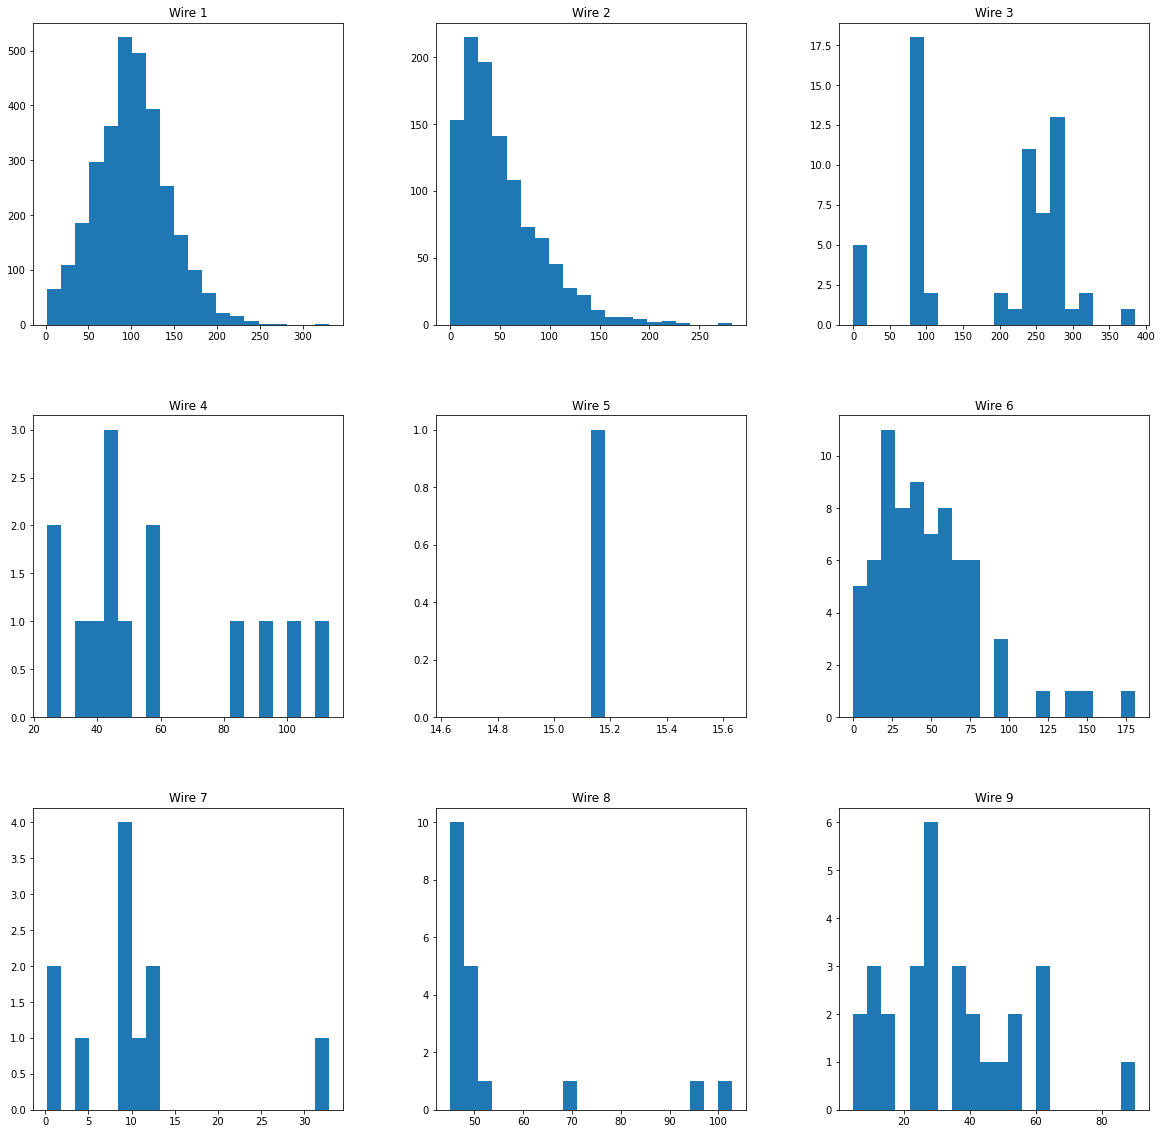

In [56]:
data_wv[data_wv[data_wv.columns.drop('key')] > 0].drop('key', axis=1).hist(
    bins=20,
    figsize=(20, 20),
    grid=False
)

In [57]:
data_wv.info(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3081 non-null   float64
 2   Wire 2  3081 non-null   float64
 3   Wire 3  3081 non-null   float64
 4   Wire 4  3081 non-null   float64
 5   Wire 5  3081 non-null   float64
 6   Wire 6  3081 non-null   float64
 7   Wire 7  3081 non-null   float64
 8   Wire 8  3081 non-null   float64
 9   Wire 9  3081 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


#### Время

Данная таблица не понадобится нам для анализа, однако мы можем проанализировать данные в ней.

In [58]:
data_wt = pd.read_csv('/datasets/data_wire_time_new.csv') # данные о времени проволочных метериалов

data_wt.head(10)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,2019-05-03 13:57:27,2019-05-03 13:48:52,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,2019-05-03 14:18:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,2019-05-03 15:01:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,2019-05-03 15:45:44,2019-05-03 15:39:37,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,2019-05-03 16:27:00,2019-05-03 16:22:36,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Существуют данные о 3081 партии.

In [59]:
len(data_wt['key'].unique())

3081

При этом максимальный номер партии -- 3241. Пропущенно 160 партий.

In [60]:
data_wt['key'].unique()

array([   1,    2,    3, ..., 3239, 3240, 3241])

Ни для одной из партий не требовалось засыпать проволочные материалы несколько раз. (или в данной таблице представлено начальное/конечное/среднее/примерное время для всех засыпок на каждой партии)

In [61]:
data_wt['key'].duplicated().sum()

0

Можно заполнить пропуски нулями, также как было сделано с соответсвующей таблицей по объёму.

In [62]:
data_wt = data_wt.fillna(0)

Для каждой из партий требовалась засыпка хотябы одного из типов проволочных материалов.

In [63]:
(data_wt[data_wt.columns.drop('key')].T.sum() <= 0).sum()

0

In [64]:
data_wt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3081 non-null   object
 2   Wire 2  3081 non-null   object
 3   Wire 3  3081 non-null   object
 4   Wire 4  3081 non-null   object
 5   Wire 5  3081 non-null   object
 6   Wire 6  3081 non-null   object
 7   Wire 7  3081 non-null   object
 8   Wire 8  3081 non-null   object
 9   Wire 9  3081 non-null   object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


---

<div class="alert alert-info">
<b>Комментарий:</b>
<br>Каждый раздел содержит мини-вывод, который начинается под чертой (кроме "Анализа", который сам по себе представляет из себя некий вывод).
</div>

В оригинальных данных существовало большое количество пропусков. В особенности хотелось бы обратить внимание на пропуски партий, которые присутсвуют во всех таблицах и не носят постоянный характер. Данный вид пропусков может быть связан как с технической ошибкой при выгрузке данных так и с отсутвием заполнения на этапе записи, поскольку некоторые сплавы могли быть сочтены удовлетворительными при первой проверке на этапе легирования и, как следствие, не требовали продувку и/или загрузку сыпучих и/или проволочных материалов, как следствие данные о таких партиях могли быть не записаны из-за отсутсвия действий.

В противовес описанию в оригиналных данных отсутствуют записи о нескольких продувках и засыпках сыпучих и проволочных материалов. Возможно несколько причин, объясняющих данное несоответсвие:

    1. Описание неверно. Засыпки и продувка осуществляются только один раз для каждой партии.
    2. Данные неверны. В силу каких-либо причин в таблицу записывается только первая/последняя/средняя/случайная/суммарная запись о проделаных операциях.
    3. Система неисправна. По какой-то причине датчик не проверяет соответсвующий параметр характеристики стали после произведённой операции.
    4. Данные скорректированы или отобраны таким образом, чтобы в них присутсвовала только одна запись о продувке и засыпке.
    5. Нам повезло и для всех 3241 партий не потребовалось проводить последующих продувок и засыпок.

Также хотелось бы отметить схожесть структур таблиц о температуре и об электродах, поскольку это единственные таблицы имеющие неуникальные записи о партиях. При внимательном просмотре данных таблиц можно обнаружить, что данные таблицы похожи не только структурно но и связаны на уровне составляющих: за 10 с перед каждым нагревом происходит замер температуры. Это позволяет предположить, что термометр и электроды для нагрева связаны аппаратно теснее остальных устройств, возможно они даже находятся в одном и том же месте. Из описания нам известно, что электроды расположены на крышке, и если термометр расположен там же, то это поднимает вопрос о достаточности с точки зрения исследования температуры проводимых таким образом измерений.

В отдельных случаях разница температуры между выходом и входом составляет сотню градусов, однако медиана такой разницы оказалась немногим больше нуля.

## Предобработка

Поскольку описание системы сбора данных и технического процесса не только не отличается подробностью, но и, как можно видеть из вывода предыдущего раздела, обладает в ряде случаев сомнительной надёжностью, нам придётся выдвинуть ряд предположений от которых мы будем вынуждены отталкиваться в ходе дальнейшего анализа.
 
    1. Будем называть самую раннюю запись об измерении температуры для конкретной партии -- температурой на входе.
    2. Будем называть самую позднюю запись об измерении температуры для конкретной партии -- температурой на выходе.
    3. Будем считать, что температура на выходе зависит от температуры на входе.
    4. Будем считать, что длительность по времени между записями температуры на входе и температуры на выходе оказывает влияние на разницу между температурами на входе и на выходе, поскольку при большей разницы во времени сталь в ковше может остывать.
    5. Будем считать температуру постоянной во всём объёме.
    6. Будем считать, что реактивная мощность не оказывает на температуру внутри ковша никакого влияния. При построении дальнейших моделей будем ориентироваться только на активную мощность. Это тем более справедливо из-за высокой степени корреляции этих двух величин.
    7. Будем считать, что длительность нагрева дугой оказывает влияние на разницу между температурами на входе и на выходе, поскольку помимо этой длительности мы знаем мощность, передаваемую от дуги сплаву ковша, что является работой, а значит энергией, а значит оказывает прямое влияние на изменение температуры.
    8. Будем счиать, что продувы и засыпки различных материалов происходят мнгновенно и оказывают влияние на разницу температур между выходом и входом, причём различные материалы могут оказывать различное влияние при одинаковом объёме, поскольку могут иметь различные теплоёмкости.
    
Таким образом модель предсказания температуры, которую нам необходимо построить, это модель, предсказывающая температуру на выходе. Для того, чтобы она успешно справилась с этой задачей ей нужно передать:

    1. Температуру на входе.
    2. Длительность всего процесса.
    3. Энергию, передаваемую от дуги.
    4. Количество прогревов дугой.
    5. Объёмы всех сыпучих материалов.
    6. Объёмы всех проволочных материалов.
    7. Объём газа для продувки.

### Температура на входе

Первой в сборный датасет добавим температуру на входе.

In [65]:
data = pd.DataFrame(
    data_t.groupby('key').apply(
        lambda x: x[x['Время замера'] == x['Время замера'].min()]
    ).set_index('key')['Температура']
)
data.columns = ['T_вх']

### Длительность

Добавим длительность нахождения стали в ковше, определяя её как разницу по времени между самой первой записью в таблице замера температуры и последней. Выразим длительность в секундах.

In [66]:
data = data.join(
    (data_t.groupby('key').apply(
        lambda x: x[x['Время замера'] == x['Время замера'].max()]
    ).set_index('key')['Время замера'] - \
    data_t.groupby('key').apply(
        lambda x: x[x['Время замера'] == x['Время замера'].min()]
    ).set_index('key')['Время замера']).dt.total_seconds(),
    how='inner'
)
data.columns = ['T_вх', 'dt']

### Энергия от дуги

Для нахождения данного показателя можно просуммировать значения реактивной мощности, умноженные на соответствующие промежутки времени.

In [67]:
data = data.join(
    pd.concat([
        data_e['key'],
        (data_e['Конец нагрева дугой'] - data_e['Начало нагрева дугой']).dt.total_seconds() * data_e['Активная мощность']
    ], axis=1).groupby('key').sum(),
    how='inner'
)
data.columns = ['T_вх', 'dt', 'E']

### Количество прогревов

Количество прогревов дугой поможет дать представление о плотности с которой энергия передаётся от дуги в сплав.

In [68]:
data = data.join(
    data_e.groupby('key').count()['Активная мощность'],
    how='inner'
)
data.columns = ['T_вх', 'dt', 'E', 'n']

### Сыпучие материалы

Далее добавим информацию об объёме сыпучих материалов.

In [69]:
data = data.join(
    data_mv.set_index('key'),
    how='inner'
)

### Проволочные материалы

Кроме того, можно добавить значения объёмов проволочных материалах.

In [70]:
data = data.join(
    data_wv.set_index('key'),
    how='inner'
)

### Газ

Добавим стобец с объёмами газа.

In [71]:
data = data.join(
    data_g.set_index('key'),
    how='inner'
)

### Температура на выходе

Помимо всего прочего добавим целевой признак в итоговый датасет.

In [72]:
data = data.join(
    data_t.groupby('key').apply(
        lambda x: x[x['Время замера'] == x['Время замера'].max()]
    ).set_index('key')['Температура'],
    how='inner'
)
data.columns = ['T_вх', 'dt', 'E', 'n', 'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6',
       'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12',
       'Bulk 13', 'Bulk 14', 'Bulk 15', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4',
       'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9', 'Газ 1', 'T_вых']

---

В данном разделе был получен датасет, который можно использовать для дальнейшего анализа и построения моделей. В ходе получения этой таблицы было потеряно ~30% данных. При этом большинство потерь произошло после отказа рассмотрения партий с пропусками температуры. В следующем разделе будет произведено разделение текущего датасета на выборки. Информацию о полученных данных можно посмотреть ниже.

In [73]:
data.head(10)

,T_вх,dt,E,n,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,...,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,Газ 1,T_вых
key,,,,,,,,,,,,,,,,,,,,,
1,1571.0,1714.0,628.616930,5,0.0,0.0,0.0,43.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.749986,1613.0
2,1581.0,1265.0,395.281800,4,0.0,0.0,0.0,73.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.555561,1602.0
3,1596.0,1753.0,581.774624,5,0.0,0.0,0.0,34.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.554793,1599.0
4,1601.0,1220.0,543.710274,4,0.0,0.0,0.0,81.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.841219,1625.0
5,1576.0,1536.0,412.180480,4,0.0,0.0,0.0,78.0,0.0,0.0,...,9.114560,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.413692,1602.0
6,1543.0,1497.0,691.669688,4,0.0,0.0,0.0,117.0,0.0,0.0,...,9.114560,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.273392,1596.0
7,1586.0,1744.0,491.550467,4,0.0,0.0,0.0,117.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.836267,1599.0
8,1577.0,1615.0,496.597268,4,0.0,0.0,0.0,99.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.171553,1598.0
9,1587.0,1811.0,464.455338,5,0.0,0.0,0.0,117.0,0.0,0.0,...,9.143681,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.216623,1592.0


In [74]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2324 entries, 1 to 2499
Data columns (total 30 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   T_вх     2324 non-null   float64
 1   dt       2324 non-null   float64
 2   E        2324 non-null   float64
 3   n        2324 non-null   int64  
 4   Bulk 1   2324 non-null   float64
 5   Bulk 2   2324 non-null   float64
 6   Bulk 3   2324 non-null   float64
 7   Bulk 4   2324 non-null   float64
 8   Bulk 5   2324 non-null   float64
 9   Bulk 6   2324 non-null   float64
 10  Bulk 7   2324 non-null   float64
 11  Bulk 8   2324 non-null   float64
 12  Bulk 9   2324 non-null   float64
 13  Bulk 10  2324 non-null   float64
 14  Bulk 11  2324 non-null   float64
 15  Bulk 12  2324 non-null   float64
 16  Bulk 13  2324 non-null   float64
 17  Bulk 14  2324 non-null   float64
 18  Bulk 15  2324 non-null   float64
 19  Wire 1   2324 non-null   float64
 20  Wire 2   2324 non-null   float64
 21  Wire 3   2324 

Кроме того, можно посмотреть на корреляцию различных параметров датасета между собой. Можно обратить внимание, что больших значений этот параметр не достигает ни при одном из сочетаний столбцов, кроме передаваемой энергии и количестве таких передач, что даёт нам надежду на получение хороших моделей при обучении.

In [75]:
c = ['T_вх', 'dt', 'E', 'T_вых', 'n']

for (i,j) in [(i,j) for i in range(len(c)) for j in range(len(c))]:
    if (i <= j):
        continue
    print(c[i], 'x', c[j], ' : ', data[c[i]].corr(data[c[j]]))

dt x T_вх  :  0.21078551206598034
E x T_вх  :  -0.34522202273469055
E x dt  :  0.5094847182689521
T_вых x T_вх  :  0.30188233196167763
T_вых x dt  :  0.09612550000239524
T_вых x E  :  0.2578623524608949
n x T_вх  :  -0.1768607516492163
n x dt  :  0.5953285174281151
n x E  :  0.712168567674093
n x T_вых  :  0.18027609674146752


При рассмотрении корреляции всех признаков друг с другом становиться понятно, что по какой-то странной причине существует высокая положительная корреляция между `Wire 8` и `Bulk 9`.

In [81]:
c = ['T_вх', 'dt', 'E', 'n', 'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6',
       'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12',
       'Bulk 13', 'Bulk 14', 'Bulk 15', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4',
       'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9', 'Газ 1', 'T_вых']

for (i,j) in [(i,j) for i in range(len(c)) for j in range(len(c))]:
    if (i <= j):
        continue
    print(c[i], 'x', c[j], ' : ', data[c[i]].corr(data[c[j]]))
    if (abs(data[c[i]].corr(data[c[j]])) > 0.8):
        print('---')

dt x T_вх  :  0.21078551206598034
E x T_вх  :  -0.34522202273469055
E x dt  :  0.5094847182689521
n x T_вх  :  -0.1768607516492163
n x dt  :  0.5953285174281151
n x E  :  0.712168567674093
Bulk 1 x T_вх  :  0.07909811865644976
Bulk 1 x dt  :  0.14442885785774112
Bulk 1 x E  :  0.09564143925320172
Bulk 1 x n  :  0.0976885544840618
Bulk 2 x T_вх  :  0.14154729859775098
Bulk 2 x dt  :  0.26747993070774656
Bulk 2 x E  :  0.03833076801603109
Bulk 2 x n  :  0.09314541039646998
Bulk 2 x Bulk 1  :  0.224676730751739
Bulk 3 x T_вх  :  -0.11337968245088022
Bulk 3 x dt  :  0.023019294000222113
Bulk 3 x E  :  0.08880541221186014
Bulk 3 x n  :  0.10730792142396688
Bulk 3 x Bulk 1  :  -0.011538269619879247
Bulk 3 x Bulk 2  :  -0.04695287236976675
Bulk 4 x T_вх  :  0.16548353362112317
Bulk 4 x dt  :  0.002019205954924314
Bulk 4 x E  :  -0.0208985326899991
Bulk 4 x n  :  -0.004955173623246604
Bulk 4 x Bulk 1  :  0.04166157683487794
Bulk 4 x Bulk 2  :  0.04075599061336805
Bulk 4 x Bulk 3  :  -0.2955259

Поскольку `Wire 8` и `Bulk 9` имеют высокую корреляцию, удалим один из них, допустим `Wire 8`. В дальнейшем все вывод, которые мы будем делать о `Bulk 9` также будем относить и к `Wire 8`. Кроме того можно удалить `Wire 5`, поскольку этот столбец является пустым.

In [84]:
data = data.drop(['Wire 8', 'Wire 5'], axis=1)

Также можно посмотреть на распределения величин в получившейся таблице.

Text(0.5, 0, 'температура, °C')

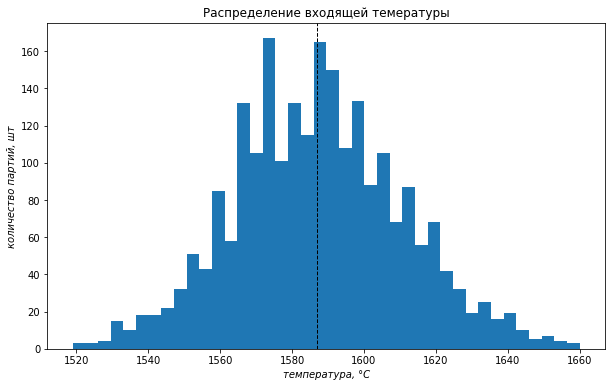

In [85]:
data['T_вх'].hist(
    bins=40,
    figsize=(10,6),
    grid=False
)
plt.axvline(x=data['T_вх'].median(), color='#000000', ls='--', linewidth=1)
plt.title('Распределение входящей темературы')
plt.ylabel('количество партий, шт', style='italic')
plt.xlabel('температура, °C', style='italic')

Text(0.5, 0, 'время, с')

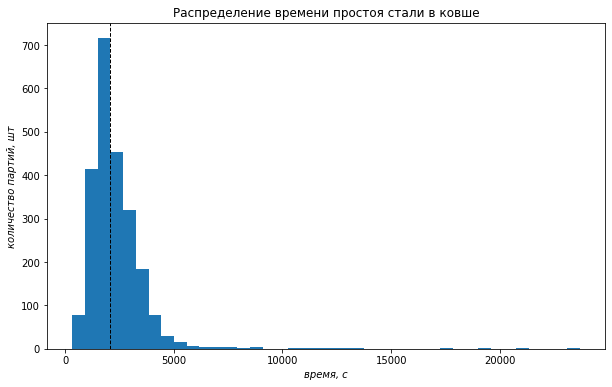

In [86]:
data['dt'].hist(
    bins=40,
    figsize=(10,6),
    grid=False
)
plt.axvline(x=data['dt'].median(), color='#000000', ls='--', linewidth=1)
plt.title('Распределение времени простоя стали в ковше')
plt.ylabel('количество партий, шт', style='italic')
plt.xlabel('время, с', style='italic')

Text(0.5, 0, 'энергия, Дж')

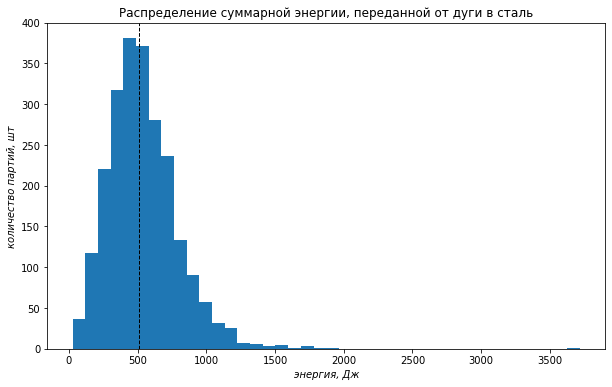

In [88]:
data['E'].hist(
    bins=40,
    figsize=(10,6),
    grid=False
)
plt.axvline(x=data['E'].median(), color='#000000', ls='--', linewidth=1)
plt.title('Распределение суммарной энергии, переданной от дуги в сталь')
plt.ylabel('количество партий, шт', style='italic')
plt.xlabel('энергия, Дж', style='italic')

Text(0.5, 0, 'количество, шт')

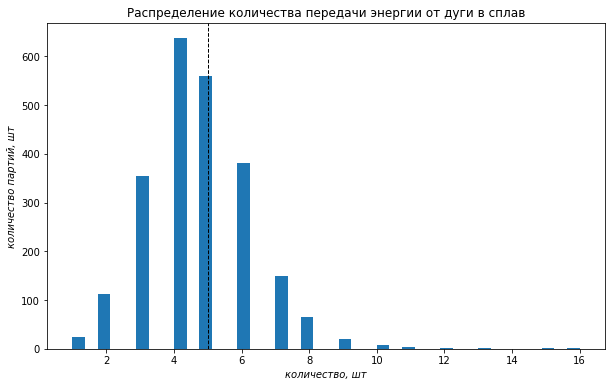

In [89]:
data['n'].hist(
    bins=40,
    figsize=(10,6),
    grid=False
)
plt.axvline(x=data['n'].median(), color='#000000', ls='--', linewidth=1)
plt.title('Распределение количества передачи энергии от дуги в сплав')
plt.ylabel('количество партий, шт', style='italic')
plt.xlabel('количество, шт', style='italic')

Text(0.5, 0, 'температура, °C')

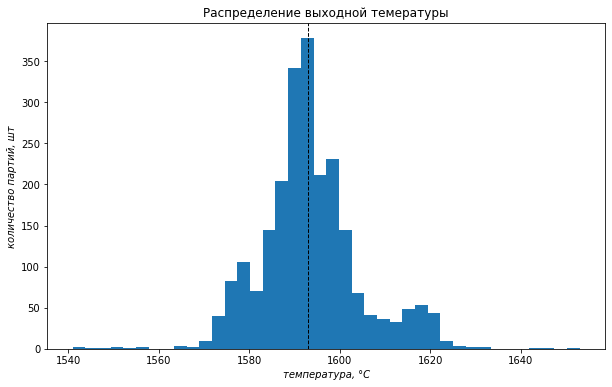

In [90]:
data['T_вых'].hist(
    bins=40,
    figsize=(10,6),
    grid=False
)
plt.axvline(x=data['T_вых'].median(), color='#000000', ls='--', linewidth=1)
plt.title('Распределение выходной темературы')
plt.ylabel('количество партий, шт', style='italic')
plt.xlabel('температура, °C', style='italic')

## Подготовка

Отделим целевые признаки от нецелевых и разделим исходные данные на обучающую, валидационную и тестовую выборки в соотношение (2:1:1) (50%:25%:25%).

In [91]:
x = data.drop('T_вых', axis=1)
y = data['T_вых']

random_state = 171123 # random_state

# разбиение признаков
x_train, x_valid, x_test = \
              np.split(x.sample(frac=1, random_state=random_state), 
                       [int(.5 * len(x)), int(.75 * len(x))])

# разбиение целевого признака
y_train, y_valid, y_test = \
              np.split(y.sample(frac=1, random_state=random_state), 
                       [int(.5 * len(y)), int(.75 * len(y))])

Поскольку обучение моделей обычно требует значительных ресурсов, удалим все данные, непредназначенные для этой задачи.

In [92]:
del data
del data_e
del data_mv
del data_mt
del data_g
del data_t
del data_wv
del data_wt

In [93]:
x_train.shape, x_valid.shape, x_test.shape

((1162, 27), (581, 27), (581, 27))

---

В данном разделе были подготовлены признаки и ресурсы компьютера для дальнейшего обучения.

Поскольку в данном анализе нашей основной задачей является исследование влияния различных признаков на выходную температуру а не создание "боевой" модели, предсказывающей эту температуру в тестовой выборке мы будем использовать обработанные значения из раздела "Данные" в которых отсутсвуют пропуски и некорретнтые с точки зрения физики величины, несмотря на то, что в реальности эти вещи, по-видимому, могут присутсвовать в данных.

## Обучение

Обучим несколько моделей на тестовых данных и найдём среднюю абсолютную разницу между прогнозируемой выходной температурой и выходной температурой в валидационных данных. Соберём данные об обучении в таблицу для последующего анализа.

In [150]:
m = pd.DataFrame(data={'model': [], 'mae': []})

### Линейная регрессия

Обучим модель линейной регрессии.

In [151]:
model = LinearRegression()

results = cross_val_score(model,
                          pd.concat([x_train, x_valid]),
                          pd.concat([y_train, y_valid]),
                          cv=8,
                          scoring='neg_mean_absolute_error'
                         )

m.loc[len(m)] = [str(model) + ' cross_val_score(cv=8)', -results.mean()]

print('MAE модели LinearRegression:', -results.mean())

MAE модели LinearRegression: 6.594382266836903


### Случайный лес

Обучим модель случайного леса, попробуем подобрать некоторые параметры в данной модели с помощью цикла.

In [152]:
mae0 = 100
for (i,j,k) in [(i,j,k) for i in range(120,141,10) for j in range(8,12) for k in range(2,6)]:
    model = RandomForestRegressor(
        random_state=random_state,
        n_estimators=i,                      # количество деревьев
        max_depth=j,                         # максимальная глубина
        min_samples_leaf=k
    )
    
    st = time.time()
    model.fit(x_train,y_train)
    predict = model.predict(x_valid)
    te = time.time()

    mae = mean_absolute_error(predict,y_valid)
    print(i,j,k, ' : ', te - st, 'c')
    print('mae:', mae, '\n')
    if (mae < mae0):
        mae0 = mae
        bm = model
        t = te - st

print('MAE модели RandomForestRegressor:', mae0)

m.loc[len(m)] = [bm, mae0]

120 8 2  :  0.5743660926818848 c
mae: 7.075098950720674 

120 8 3  :  0.5823397636413574 c
mae: 7.0901370025247585 

120 8 4  :  0.568152666091919 c
mae: 7.0737921777388895 

120 8 5  :  0.5477466583251953 c
mae: 7.082146916734206 

120 9 2  :  0.6173741817474365 c
mae: 7.084150182578299 

120 9 3  :  0.6085331439971924 c
mae: 7.108436574454476 

120 9 4  :  0.5817775726318359 c
mae: 7.070897030876912 

120 9 5  :  0.5957622528076172 c
mae: 7.097213386783502 

120 10 2  :  0.6453287601470947 c
mae: 7.0808783686465375 

120 10 3  :  0.6233739852905273 c
mae: 7.110635801775818 

120 10 4  :  0.5959510803222656 c
mae: 7.090898334938329 

120 10 5  :  0.5873301029205322 c
mae: 7.108447532395355 

120 11 2  :  0.6853501796722412 c
mae: 7.098816064395046 

120 11 3  :  0.6495945453643799 c
mae: 7.124107896238639 

120 11 4  :  0.6129834651947021 c
mae: 7.087276385983495 

120 11 5  :  0.5904982089996338 c
mae: 7.1065397806121275 

130 8 2  :  0.6168227195739746 c
mae: 7.068281881085005 

130

### CatBoost

Используем модель `CatBoost` для обучения.

In [154]:
model = CatBoostRegressor(random_state=random_state, 
                          verbose=False
                         )

parameters = {'learning_rate': [0.05, 0.1, 0.15], 
              'depth': [3,5,6,7,9], 
              'iterations': [10, 50, 100, 150]}

grid = GridSearchCV(estimator=model, 
                    param_grid=parameters, 
                    scoring='neg_mean_absolute_error', 
                    cv=5, 
                    verbose=2,
                    n_jobs=-1)

grid.fit(pd.concat([x_train, x_valid]), pd.concat([y_train, y_valid]))
#predict = grid.predict(x_valid)

# получаем лучшие результаты
print("MAE модели CatBoostRegressor:", round(np.mean(-grid.best_score_),4))
print('\nНаилучшие параметры:', grid.best_params_)

m.loc[len(m)] = [str(grid.best_params_), round(np.mean(-grid.best_score_),4)]

Fitting 5 folds for each of 60 candidates, totalling 300 fits


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

[CV] END .........depth=3, iterations=10, learning_rate=0.05; total time=   0.6s
[CV] END .........depth=3, iterations=10, learning_rate=0.05; total time=   1.0s
[CV] END .........depth=3, iterations=10, learning_rate=0.05; total time=   1.3s
[CV] END .........depth=3, iterations=10, learning_rate=0.05; total time=   1.7s
[CV] END .........depth=3, iterations=10, learning_rate=0.05; total time=   1.1s
[CV] END ..........depth=3, iterations=10, learning_rate=0.1; total time=   1.9s
[CV] END ..........depth=3, iterations=10, learning_rate=0.1; total time=   1.9s
[CV] END ..........depth=3, iterations=10, learning_rate=0.1; total time=   1.2s
[CV] END ..........depth=3, iterations=10, learning_rate=0.1; total time=   1.4s
[CV] END ..........depth=3, iterations=10, learning_rate=0.1; total time=   1.1s
[CV] END .........depth=3, iterations=10, learning_rate=0.15; total time=   1.9s
[CV] END .........depth=3, iterations=10, learning_rate=0.15; total time=   2.0s
[CV] END .........depth=3, i

---

В данном разделе были рассмотрены три модели, но наименьшая средняя абсолютная разница между прогнозируемой выходной температурой и выходной температурой в валидационных данных оказалась у модели линейной регрессии. Возьмём её для последующего анализа.

In [155]:
m

,model,mae
0,LinearRegression() cross_val_score(cv=8),6.594382
1,"(DecisionTreeRegressor(max_depth=9, max_featur...",7.056765
2,"{'depth': 6, 'iterations': 150, 'learning_rate...",6.416000


## Лучшие модель

Проверим модель `CatBoostRegressor` на тестовых данных.

In [175]:
model_c = CatBoostRegressor(random_state=random_state, 
                          verbose=False,
                          learning_rate=0.1,
                          depth=6,
                          iterations=150
                         )

model_c.fit(pd.concat([x_train, x_valid]), pd.concat([y_train, y_valid]))
predict = grid.predict(x_test)

print('MAE модели CatBoostRegressor:', mean_absolute_error(predict,y_test))

MAE модели CatBoostRegressor: 6.249923888726989


Кроме того, оценим метрику MAE для второй по качеству модели, а именно для модели линейной регрессии.

In [180]:
model_lr = LinearRegression()

model_lr.fit(x_train,y_train)
predict = model_lr.predict(x_valid)

mean_absolute_error(predict,y_valid)

6.808573767532844

---

В данном разделе получена модель с метрикой MAE находящейся в допустимом пределе.

## Анализ

Оценим важность влияния на выходную температуру каждого из факторов, которые мы используем в данном анализе, используя наиболее точную из полученых моделей.

<AxesSubplot:xlabel='feature'>

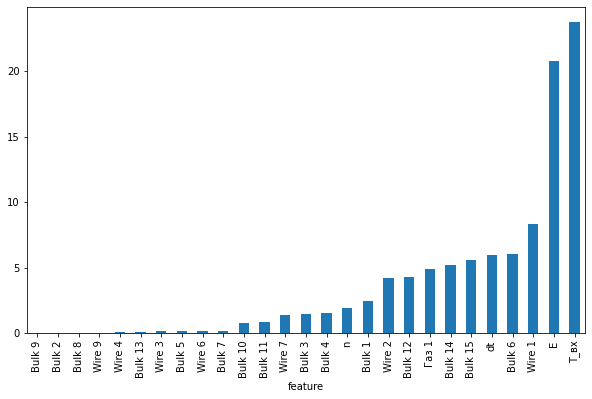

In [178]:
с = ['T_вх', 'dt', 'E', 'n', 'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6',
       'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12',
       'Bulk 13', 'Bulk 14', 'Bulk 15', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4',
       'Wire 6', 'Wire 7', 'Wire 9', 'Газ 1']

coefs_c = pd.DataFrame(
    data={
        'feature' : с,
        'importances' : model_c.feature_importances_
    },
    columns=['feature', 'importances']
)

coefs_c.sort_values(by='importances').set_index('feature').plot(kind='bar', stacked=True, figsize=(10,6), align='center', legend=False)

Из рисунка видно, что наибольшую важность в формировании итоговой температуры играют добавки `Bulk 6` и `Wire 1`, кроме того достаточно важным показателем является время простоя стали на этапе леггирования. Наиважнейшую роль играют температура входящей стали и суммарная энергия, передаваемая в сталь от электродов, что не может не удивлять.

Для получения более подробной информации о характере влияния факторов, влияющих на выходную температуру нормируем коэфициенты модели линейной регрессии и отсортируем их. Сопаставим эти коэфициенты с признаком их породившим оценив, таким образом, влияние признаков на выходную температуру.

<AxesSubplot:xlabel='feature'>

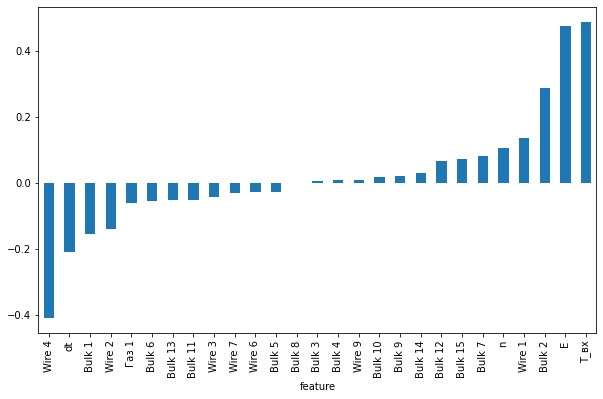

In [179]:
#model.intercept_
с = ['T_вх', 'dt', 'E', 'n', 'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6',
       'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12',
       'Bulk 13', 'Bulk 14', 'Bulk 15', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4',
       'Wire 6', 'Wire 7', 'Wire 9', 'Газ 1']

# нормируем данные
scalerx = StandardScaler().fit(x_train)
scalery = StandardScaler().fit(y_train.values.reshape(-1,1))

normed_x = scalerx.transform(x_train)
normed_y = scalery.transform(y_train.values.reshape(-1,1))

normed_y = normed_y.ravel() # переход к вектору

# обучение нормированных данных
lr = LinearRegression()
lr.fit(normed_x, normed_y)

coefs = pd.DataFrame(
    data={
        'feature' : с,
#        'coef' : model.coef_,
        'norm_coef' : lr.coef_,
#        'scalex' : scalerX.scale_,
#        'scaley' : scalery.scale_[0],
    },
#    columns=['feature', 'coef', 'norm_coef', 'scalex', 'scaley']
    columns=['feature', 'norm_coef']
)
#coefs['rescaled_coef'] = coefs2.norm_coef / coefs2.scalex * coefs2.scaley
coefs.sort_values(by='norm_coef').set_index('feature').plot(kind='bar', stacked=True, figsize=(10,6), align='center', legend=False)

Данный рисунок даёт некоторое представление о том, как признакивлияют на температуру стали. Стоит сказать сказать, что данный анализ не даёт понять причину снижения температуры а только указывает на наличие зависимости одного параметра от другого. Так, например, в таблице можно увидеть отрицательный коэфициент температуры для проволочного материала `Wire 4`, но таблица не даёт представления о том является ли такой коэфициент следсвием добавления `Wire 4`, изначальным отсутсвием в стали `Wire 4` или следствием иных причин связаных с `Wire 4`. Чтобы не выдумывать сложных формулировок мы будем говорить о прямой зависимости между коэфициентом и выходной температурой, например, мы будем говорить, что добавление некоторых засыпок (`Bulk 2`, `Bulk 9`) увеличивает выходную температуру стали, добавление других (`Wire 4`, `Wire 8`) её уменьшают, однако, строго говоря это может быть не так.

При этом среднее влияние засыпочных материалов увеличивает тепературу, тогда как проволочные материалы её уменьшают.

In [222]:
c = ['Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6',
       'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12',
       'Bulk 13', 'Bulk 14', 'Bulk 15']

print('Среднее влияние засыпочных материалов:\n', coefs2.set_index('feature').loc[c].mean())

c = ['Wire 1', 'Wire 2', 'Wire 3', 'Wire 4',
       'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9']

print('Среднее влияние проволочных материалов:\n', coefs2.set_index('feature').loc[c].mean())

Среднее влияние засыпочных материалов:
 norm_coef    0.030312
dtype: float64
Среднее влияние проволочных материалов:
 norm_coef   -0.078541
dtype: float64


Простой стали снижает температуру, однако больше всего вклад в уменьшение температуры даёт добавление проволочного материала `Wire 4`. Помио `Wire 4` большой вклад в уменьшение температуры дают `Wire 8`, `Bulk 1`, `Wire 2`. Продувка газом также снижает температуру, но её влияние на порядок меньше, чем влияние простоя стали.

Повышает температуру энергия, передаваема от дуги в сталь и входная температура стали. Кроме того добавление некоторых засыпочных (`Bulk 2`, `Bulk 9`) и проволочных (`Wire 1`) материалов. Увеличение количества прогревов дугой также увеличивает выходную температуру, поскольку, видимо, изменяется плотность передачи энергии от дуги в сталь.

## Рекомендации

В данной работе была построена модель, предсказывающая температуру стали в котле на основе ряда признаков. Далее данные признаки были соотнесены с коэффициентами обученой модели по которой был сделан вывод о влиянии признаков на выходную температуру. 

На основании этого вывода можно сделать вывод о том, что взаимодействие со сталью, которой необходима добавка `Bulk 2`, `Bulk 9` и `Wire 1` и отсутсвует нужда в добавлении `Wire 4`, `Wire 8`, `Bulk 1`, `Wire 2` может увеличить выходную температуру и, как следсвие позитивно сказаться на энергопотреблении.

Увеличение температуры входящей стали также поможет увеличить температуру и экономию энергии на этапе леггирования.

Кроме того с точки зрения увеличения температуры было бы неплохо увеличить количество нагревов при сохранении суммарной энергии, передаваемой от нагревателя в сталь. В идеале можно было бы добиться континуального нагрева, т.е. нагревать сталь с постоянной температурой в течении всего процесса легиирования, предварительно высчитав необходимое значение этой температуры, сделав все необходимые для этого замеры.

Положительно на энергопотребление также могло бы сказаться снижение времени простоя стали на этапе легирования. Первым шагом в этом направлении могло бы стать уменьшение десятисекундного промежутка между нагревом и замером температуры. Возможно стоит оптимизировать и другие процессы с точки зрения скорости.



Безотносительно коэфициентов модели также можно дать некоторые рекомендации по с, простейшая из которых это снижение реак

Расположение термометра в месте с наименьшей температурой является хорошим решением с точки зрения контроля качества продукта, однако не лучшим с точки зрения экономии электроэнергии. Было бы интересно изучить, распределение температуры внутри самого ковша, для этого потребовалось бы несколько термометров, но это может навести на некоторые мысли по контролю температуры. Если данная сталь имеет высокую теплоёмкость при большом объёме ковша можно было бы попробовать передать часть температуры от более нагретых участков расплава к менее нагретым, используя для этого некоторую "мешалку". Вопрос целесообразности такого решения представляет из себя отдельное исследование, включающее упомянутое изучение распределения температуры.